# Introduction to Data Science – Lecture 12 - APIs
*COMP 5360 / MATH 4100, University of Utah, http://datasciencecourse.net/*

In this lecture we will explore how we can extract data from web-APIs. The first part of this tutorial is based on [this blog](https://www.dataquest.io/blog/python-api-tutorial/).

API stands for **A**pplication **P**rogramming **I**nterface. It is supposed to be a **well defined interface** for consuming data (in contrast to web-scraping), or, more generally, for the **interaction with a remote program** on a server. APIs aren't only generated so that you can read data; they're often designed so that you could write custom software to interact with the API. You could, for example, write your own twitter client! 

APIs are usually well documented, as the organization that provides APIs wants you to use them. 

Here are a couple of examples of sites that have documented APIs:

 * [StackExchange](https://api.stackexchange.com/docs)  
 * [Twitter](https://dev.twitter.com/rest/public)
 * [Facebook](https://developers.facebook.com/docs/graph-api)
 * [KEGG](http://www.genome.jp/kegg/rest/keggapi.html) 
 * [Google Maps](https://developers.google.com/maps/) 
 * and many many more. 
 
Most APIs require some form of authentication and have rules on what you're allowed to do and what not. Follow those rules, or you will be blocked faster than you can say `GET`. 
 
An API works a lot like working with a website, but instead of a human in front of the screen, it's computers talking to each other. 

We'll be using the dominant form of APIs, REST (REpresentational State Transfer), which are now the dominant way of exposing and API on the web. REST APIs use an [URI](https://en.wikipedia.org/wiki/Uniform_Resource_Identifier) (a Uniform Resource Identifier; URLs are one specific form of URIs) to specify what you want to do with and API.

All API methods in REST are relative to a base URL. E.g., for twitter this would be
```
https://api.twitter.com/1.1/
```

A query would look like this: 

```
https://api.twitter.com/1.1/search/tweets.json?q=%40twitterapi
```

REST APIs can return data in different forms, the most common ones are JSON and XML, and of those two, JSON is now dominant. 

JSON stands for JavaScript Object Notation, and is a pretty convenient format, as we'll see. 
 

Let's start with a very simple example, retrieving the current position of the ISS. We will be using the [requests](https://requests.readthedocs.io/en/master/) library, which will handle our communication with the server.

In [1]:
import requests 
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get( "http://api.open-notify.org/iss-now.json" )

response

<Response [200]>

That looks good, we've received a response and it has status 200. What does the 200 mean? It's a status code - you've probably seen the "Error 404" on the internet. 

Here are a couple of codes:

 * **200** – everything went okay, and the result has been returned (if any)
 * **301** – the server is redirecting you to a different endpoint. This can happen when a company switches domain names, or an endpoint name is changed.
 * **401** – the server thinks you’re not authenticated. This happens when you don’t send the right credentials to access an API (we’ll talk about authentication later).
 * **400** – the server thinks you made a bad request. This can happen when you don’t send along the right data, among other things.
 * **403** – the resource you’re trying to access is forbidden – you don’t have the right permissions to see it.
 * **404** – the resource you tried to access wasn’t found on the server.

Let's try to get a response with a wrong URL:

In [2]:
response_failed = requests.get("http://api.open-notify.org/iss")

response_failed

<Response [404]>

We used the get methods to put in a GET request. There are four different types of requests: 

![Request types](requests.png)
[Source](https://en.wikipedia.org/wiki/Representational_state_transfer)

Let's look at the payload of our previous, successful response:

In [3]:
response.content

b'{"timestamp": 1686586518, "message": "success", "iss_position": {"latitude": "26.2475", "longitude": "-130.6918"}}'

We can already see that this is JSON (though it is stored a `bytes` object), but we can check formally:

In [4]:
response.headers['content-type']

'application/json'

We can decode this byte object, then the JSON will be readable. 

In [11]:
import json

response_j = response.content.decode( "utf-8" )
print( "Type: ", type( response_j ) )
print( "Value:", response_j )


Type:  <class 'str'>
Value: {"timestamp": 1686586518, "message": "success", "iss_position": {"latitude": "26.2475", "longitude": "-130.6918"}}


Let's take a look at the JSON here:

```JSON
{
  "iss_position": {
    "latitude": -30.005751854107206, 
    "longitude": -104.20085371352678
  }, 
  "message": "success", 
  "timestamp": 1475240215
}
```

This looks a lot like a dictionary! We have key-value pairs. 

We can use the [json library](https://docs.python.org/3/library/json.html) to convert JSON strings into an easy to use dictionary:

In [12]:
import json

# loads converts a string (that contains json data) into a dictionary
response_d = json.loads( response_j )

print( type( response_d ) )

# dumps will "pretty print" the dictionary
print( json.dumps( response_d, indent = 4 ) )

print( "position:", response_d[ "iss_position" ] )

<class 'dict'>
{
    "timestamp": 1686586518,
    "message": "success",
    "iss_position": {
        "latitude": "26.2475",
        "longitude": "-130.6918"
    }
}
position: {'latitude': '26.2475', 'longitude': '-130.6918'}


Or, not surprisingly, pandas can also load a jsong object:

In [13]:
import pandas as pd 

df = pd.read_json( response_j )
df

,timestamp,message,iss_position
latitude,2023-06-12 16:15:18,success,26.2475
longitude,2023-06-12 16:15:18,success,-130.6918


This isn't quite what we want - we probably want one row per timestamp and longitude and latitude as columns:

In [14]:
def flatten(response_d):
    response_d["latitude"]  = response_d["iss_position"]["latitude"]
    response_d["longitude"] = response_d["iss_position"]["longitude"]
    del( response_d["iss_position"] )
    return response_d

flatten( response_d )

{'timestamp': 1686586518,
 'message': 'success',
 'latitude': '26.2475',
 'longitude': '-130.6918'}

That looks better. Let's get a couple of positions of the ISS over time and save it as an array:

In [15]:
import time

def pull_position():
    """Retreives the position of the ISS and returns it as a flat dictionary"""
    response = requests.get( "http://api.open-notify.org/iss-now.json" )
    response_j = response.content.decode( "utf-8" )
    response_d = json.loads( response_j )
    flat_response = flatten( response_d )
    return flat_response    

iss_position = []
    
# calls pull_position 10 times with 3 seconds break
for i in range( 10 ):
    flat_response = pull_position()
    iss_position.append( flat_response )
    print( flat_response )
    time.sleep( 3 )
    
len( iss_position )

{'timestamp': 1686596900, 'message': 'success', 'latitude': '-11.2711', 'longitude': '153.2681'}
{'timestamp': 1686596903, 'message': 'success', 'latitude': '-11.1208', 'longitude': '153.3806'}
{'timestamp': 1686596906, 'message': 'success', 'latitude': '-10.9703', 'longitude': '153.4931'}
{'timestamp': 1686596909, 'message': 'success', 'latitude': '-10.8199', 'longitude': '153.6054'}
{'timestamp': 1686596912, 'message': 'success', 'latitude': '-10.6694', 'longitude': '153.7176'}
{'timestamp': 1686596915, 'message': 'success', 'latitude': '-10.5188', 'longitude': '153.8296'}
{'timestamp': 1686596918, 'message': 'success', 'latitude': '-10.3430', 'longitude': '153.9603'}
{'timestamp': 1686596921, 'message': 'success', 'latitude': '-10.1923', 'longitude': '154.0721'}
{'timestamp': 1686596924, 'message': 'success', 'latitude': '-10.0416', 'longitude': '154.1838'}
{'timestamp': 1686596927, 'message': 'success', 'latitude': '-9.8908', 'longitude': '154.2954'}


10

Now we can convert this into a nice dataframe:

In [19]:
iss_position_df = pd.DataFrame(iss_position)
iss_position_df['timestamp']  = pd.to_datetime(iss_position_df['timestamp'], unit="s")

iss_position_df = iss_position_df.set_index(pd.DatetimeIndex(iss_position_df['timestamp']))
iss_position_df["latitude"] = iss_position_df["latitude"].map(float)
iss_position_df["longitude"] = iss_position_df["longitude"].map(float)

In [20]:
iss_position_df

,timestamp,message,latitude,longitude
timestamp,,,,
2023-06-12 19:08:20,2023-06-12 19:08:20,success,-11.2711,153.2681
2023-06-12 19:08:23,2023-06-12 19:08:23,success,-11.1208,153.3806
2023-06-12 19:08:26,2023-06-12 19:08:26,success,-10.9703,153.4931
2023-06-12 19:08:29,2023-06-12 19:08:29,success,-10.8199,153.6054
2023-06-12 19:08:32,2023-06-12 19:08:32,success,-10.6694,153.7176
2023-06-12 19:08:35,2023-06-12 19:08:35,success,-10.5188,153.8296
2023-06-12 19:08:38,2023-06-12 19:08:38,success,-10.3430,153.9603
2023-06-12 19:08:41,2023-06-12 19:08:41,success,-10.1923,154.0721
2023-06-12 19:08:44,2023-06-12 19:08:44,success,-10.0416,154.1838


Let's see how the ISS moves

<Axes: xlabel='latitude', ylabel='longitude'>

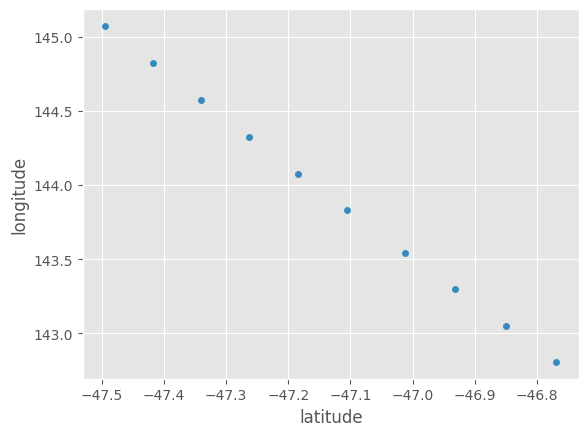

In [12]:
import matplotlib.pyplot as plt
# This next line tells jupyter to render the images inline
%matplotlib inline
plt.style.use('ggplot')
iss_position_df.plot(kind="scatter", x="latitude", y="longitude")

### Querying with Parameters

Requests can be parametrized. You can search for tweets of a specific user, for example, or [retrieve the time the ISS is over SLC](http://open-notify.org/Open-Notify-API/ISS-Pass-Times/)!

The way to query with a get request for the ISS is this:

`http://api.open-notify.org/iss-pass.json?lat=40.758701&lon=-111.876183`

We, of course, could generate that URL ourselves, but the requests library is helpful here. Since JSON is similar to dictionaries, the requests library takes dictionaries for parameters.

In [50]:
from datetime import datetime

url = "http://api.open-notify.org/iss-pass.json"
coordinates = { "lat": 40.758701, "lon": -111.876183, "n": 5 }

r = requests.get( url, params=coordinates )
data = r.json()
data

# for time in data["response"]:
#     rise = time[ "risetime" ]
#     date = datetime.fromtimestamp( rise )
#     print( date )

{'message': 'success',
 'request': {'altitude': 100,
  'datetime': 1654065702,
  'latitude': 40.758701,
  'longitude': -111.876183,
  'passes': 5},
 'response': [{'duration': 139, 'risetime': 1654108924},
  {'duration': 625, 'risetime': 1654114431},
  {'duration': 639, 'risetime': 1654120226},
  {'duration': 570, 'risetime': 1654126111},
  {'duration': 580, 'risetime': 1654131975}]}

In [51]:
timestamp = data["response"][0]["risetime"]
pd.to_datetime(timestamp,  unit="s")

Timestamp('2022-06-01 18:42:04')

So, the ISS will be visible at 6:42 PM!

### Exercise: How many Astronauts? 

Use the [Open Notify API](http://open-notify.org/Open-Notify-API/People-In-Space/) to find out how many people are in space right now.

In [13]:
r = requests.get( "http://api.open-notify.org/astros.json" )
data = r.json()
data

{'message': 'success',
 'number': 10,
 'people': [{'craft': 'ISS', 'name': 'Sergey Prokopyev'},
  {'craft': 'ISS', 'name': 'Dmitry Petelin'},
  {'craft': 'ISS', 'name': 'Frank Rubio'},
  {'craft': 'Shenzhou 15', 'name': 'Fei Junlong'},
  {'craft': 'Shenzhou 15', 'name': 'Deng Qingming'},
  {'craft': 'Shenzhou 15', 'name': 'Zhang Lu'},
  {'craft': 'ISS', 'name': 'Stephen Bowen'},
  {'craft': 'ISS', 'name': 'Warren Hoburg'},
  {'craft': 'ISS', 'name': 'Sultan Alneyadi'},
  {'craft': 'ISS', 'name': 'Andrey Fedyaev'}]}

## Libraries and Authentication

While we now have the skills to directly talk to an API, it's sometimes a little tedious. Popular APIs often have existing Python libraries that wrap around them. [Here](https://github.com/realpython/list-of-python-api-wrappers) is a long list of wrappers! 

Now we'll explore the Twitter API using the [twython library](https://github.com/ryanmcgrath/twython). Check out the [documentation](https://twython.readthedocs.io/en/latest/).

Unfortunately, most professional APIs will require you to authenticate and will limit you in what you can do – mostly they limit how much data you can retreive at a certain time. To run the following code, you'll have to put in your own credentials (sorry – I can't share mine). 

Install twython:
`pip3 install twython`

* Go to https://apps.twitter.com/ and create a new app
* Save your consumer key and consumer secret in a file `credentials.py` in the format:
```python
CONSUMER_KEY = "KEY"
CONSUMER_SECRET = "KEY"
ACCESS_TOKEN = "KEY"
ACCESS_TOKEN_SECRET = "KEY"
```

But before we get started, let's check out what [a tweet looks like](https://dev.twitter.com/overview/api/tweets):

```JSON
{'contributors': None,
  'coordinates': None,
  'created_at': 'Fri Sep 30 18:37:48 +0000 2016',
  'entities': {'hashtags': [], 'symbols': [], 'urls': [], 'user_mentions': []},
  'favorite_count': 2960,
  'favorited': False,
  'geo': None,
  'id': 781926033159249920,
  'id_str': '781926033159249920',
  'in_reply_to_screen_name': None,
  'in_reply_to_status_id': None,
  'in_reply_to_status_id_str': None,
  'in_reply_to_user_id': None,
  'in_reply_to_user_id_str': None,
  'is_quote_status': False,
  'lang': 'en',
  'place': None,
  'retweet_count': 1283,
  'retweeted': False,
  'source': '<a href="http://twitter.com/download/android" rel="nofollow">Twitter for Android</a>',
  'text': "For those few people knocking me for tweeting at three o'clock in the morning, at least you know I will be there, awake, to answer the call!",
  'truncated': False,
  'user': {'contributors_enabled': False,
   'created_at': 'Wed Mar 18 13:46:38 +0000 2009',
   'default_profile': False,
   'default_profile_image': False,
   'description': '',
   'entities': {'description': {'urls': []},
    'url': {'urls': [{'display_url': 'DonaldJTrump.com',
       'expanded_url': 'http://www.DonaldJTrump.com',
       'indices': [0, 23],
       'url': 'https://t.co/mZB2hymxC9'}]}},
   'favourites_count': 39,
   'follow_request_sent': None,
   'followers_count': 11929387,
   'following': None,
   'friends_count': 41,
   'geo_enabled': True,
   'has_extended_profile': False,
   'id': 25073877,
   'id_str': '25073877',
   'is_translation_enabled': True,
   'is_translator': False,
   'lang': 'en',
   'listed_count': 39225,
   'location': 'New York, NY',
   'name': 'Donald J. Trump',
   'notifications': None,
   'profile_background_color': '6D5C18',
   'profile_background_image_url': 'http://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_image_url_https': 'https://pbs.twimg.com/profile_background_images/530021613/trump_scotland__43_of_70_cc.jpg',
   'profile_background_tile': True,
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/25073877/1468988952',
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1980294624/DJT_Headshot_V2_normal.jpg',
   'profile_link_color': '0D5B73',
   'profile_sidebar_border_color': 'BDDCAD',
   'profile_sidebar_fill_color': 'C5CEC0',
   'profile_text_color': '333333',
   'profile_use_background_image': True,
   'protected': False,
   'screen_name': 'realDonaldTrump',
   'statuses_count': 33344,
   'time_zone': 'Eastern Time (US & Canada)',
   'url': 'https://t.co/mZB2hymxC9',
   'utc_offset': -14400,
   'verified': True}
```


In [54]:
from twython import Twython
# credentials is a local file with your own credentials. It defines CONSUMER_KEY and CONSUMER_SECRET
from credentials import * 
twitter = Twython( CONSUMER_KEY, CONSUMER_SECRET )

NameError: name 'CONSUMER_KEY' is not defined

Here, we have created the Twython library object and authenticated against our user.

Now let's search for a hashtag:

In [17]:
tag = "#ACNH"
result = twitter.search(q=tag, tweet_mode="extended")
result

pop',
    'location': 'Beebe, AR',
    'description': '',
    'url': None,
    'entities': {'description': {'urls': []}},
    'protected': False,
    'followers_count': 22,
    'friends_count': 431,
    'listed_count': 0,
    'created_at': 'Mon Feb 08 04:41:43 +0000 2016',
    'favourites_count': 772,
    'utc_offset': None,
    'time_zone': None,
    'geo_enabled': False,
    'verified': False,
    'statuses_count': 97,
    'lang': None,
    'contributors_enabled': False,
    'is_translator': False,
    'is_translation_enabled': False,
    'profile_background_color': '000000',
    'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
    'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
    'profile_background_tile': False,
    'profile_image_url': 'http://pbs.twimg.com/profile_images/1234612218634915848/JJycgOKM_normal.jpg',
    'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1234612218634915848/J

The result is an array of tweets, we can look at specific text:

In [18]:
result["statuses"][5]["full_text"]

'#AnimalCrossing #ACNH #NintendoSwitch https://t.co/T2giVZ6QJg'

Or print all the tweets:

In [19]:
for status in result["statuses"][:20]:
    print(status["full_text"])
    print("----")

RT @ephhemere_acnh: Happy Friday everyone! 🎉

#acnh #AnimalCrossingNewHorizons https://t.co/9ByQojQe4O
----
RT @m__ty416: 複数人から問い合せ頂いた
雲のマイデザ投稿しました♡⋰⋰

こちらはハロスイのキキララアイテムを
オマージュしました⌒🍬✩｡.
キキララ家具との相性抜群です！
よかったら是非使ってみてください💫☁️

🌛🧸MA-5258-8255-4028☁️🌈…
----
RT @carbonara_acnh: finally finished this area after over six months of terraforming 🐌🌿 #acnh https://t.co/nb1NNMwowf
----
garden lanterns make me happy 💫✨ #acnh https://t.co/HUHcOgMpdq
----
bien techniquement sa passe large à l'endrois de mon île ou je veux le mettre au moins j'ai le schéma  #AnimalCrossing #ACNH #NintendoSwitch https://t.co/wr3NceNSsQ
----
#AnimalCrossing #ACNH #NintendoSwitch https://t.co/T2giVZ6QJg
----
RT @kyuubi_crossing: the museum #acnh https://t.co/xO2RCiCkEm
----
RT @shiba_acnh: たーけはまだ起きていた！
パタヤ姉さんそこから見えなくない！？
期待を裏切らないねぇ～w
#あつ森 #どうぶつの森 #AnimalCrossing #ACNH #NintendoSwitch https://t.co/GJK2OifIT2
----
#動物森友會 #AnimalCrossing #ACNH #NintendoSwitch https://t.co/yzhID8JHfE
----
RT @autumnweeds: the sunken forest 🌲🍂


We can also search for tweets based on usernames:

In [20]:
result = twitter.search(q="@joe_exotic",  tweet_mode="extended")
for status in result["statuses"]:
    print(status["full_text"])
    print("----")

RT @joe_exotic: My book has been turned in. When it comes out, the world will finally know the truth because I held nothing back, so pre or…
----
RT @joe_exotic: Help me out by keeping my name alive. Go support https://t.co/okRY62lSj1 @Tiger_King_Coin https://t.co/VyM2TzCnlO https://t…
----
RT @joe_exotic: You tell me who must exploit Big Cats for profit, because if you can't walk in and love on them, they must hate you for som…
----
@joe_exotic @Tiger_King_Coin Hey Joe how are you
----
@joe_exotic @Tiger_King_Coin Support Joe, buy $TKING and soon to come, $CUB

Join our friendly community to find out more: https://t.co/lq2oIM82SD https://t.co/gS5ArPbLDa
----
RT @SwissAssAssin91: @joe_exotic @Tiger_King_Coin Crooked Carole!!! #JusticeForJoe

@Tiger_King_Coin $TKing $Cub
----
RT @joe_exotic: You tell me who must exploit Big Cats for profit, because if you can't walk in and love on them, they must hate you for som…
----
@joe_exotic @Tiger_King_Coin The picture is just so wholesome
----
@

This returns all tweets that are mentioning a username. We can also explicitly get the tweets of a person. Let's download the Tiger King's last 50 tweets. [Here](https://dev.twitter.com/rest/reference/get/statuses/user_timeline) is the relevant API documentation, [here](https://github.com/ryanmcgrath/twython/blob/master/twython/endpoints.py) are the definitions for twython.

In [21]:
#twitter = Twython(CONSUMER_KEY, CONSUMER_SECRET, ACCESS_TOKEN, ACCESS_TOKEN_SECRET)

# count is limited to the last 3200 tweets of a user, a max of 200 per request
tk_result = twitter.get_user_timeline(screen_name="joe_exotic", count=50)
tk_result

'default_profile_image': False,
   'following': None,
   'follow_request_sent': None,
   'notifications': None,
   'translator_type': 'none',
   'withheld_in_countries': []},
  'geo': None,
  'coordinates': None,
  'place': None,
  'contributors': None,
  'is_quote_status': False,
  'retweet_count': 12,
  'favorite_count': 134,
  'favorited': False,
  'retweeted': False,
  'possibly_sensitive': False,
  'lang': 'en'},
 {'created_at': 'Thu May 13 16:56:06 +0000 2021',
  'id': 1392886382465540096,
  'id_str': '1392886382465540096',
  'text': 'My attorney @JohnPhillips has worked his ass off to get me out of here and is so close to the big parade...Continue… https://t.co/LjFK8nzK3w',
  'truncated': True,
  'entities': {'hashtags': [],
   'symbols': [],
   'user_mentions': [{'screen_name': 'JohnPhillips',
     'name': 'John M. Phillips',
     'id': 58685588,
     'id_str': '58685588',
     'indices': [12, 25]}],
   'urls': [{'url': 'https://t.co/LjFK8nzK3w',
     'expanded_url': 'https://t

Let's count the numbers for the Joe_Exotic's favorites and retweets.

In [22]:
tk_favorites = []
tk_retweets = []
for status in tk_result:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    tk_favorites.append(status["favorite_count"])
    tk_retweets.append(status["retweet_count"])

@UbelikeMOE @GalleryBooks We’re hoping Joe will be allowed to sign some books
0
----
@ahodge206 @GalleryBooks Amazon is taking pre orders...Thank you!
0
----
You tell me who must exploit Big Cats for profit, because if you can't walk in and love on them, they must hate you… https://t.co/xSnAIcKN4Y
52
----
Now thru Memorial Day, save 25% off everything with promo code: MEMORIALDAY at the ONLY Joe Exotic Memorabilia Stor… https://t.co/XjZTK9HdGS
18
----
My book has been turned in. When it comes out, the world will finally know the truth because I held nothing back, s… https://t.co/btMRqrB76I
45
----
My Official Tiger King coins will help me fix children’s smiles/faces, fight justice and prison reform, and save an… https://t.co/UxJkwXqx5t
42
----
As the world fights for the truth for Don Lewis, I pray the world will continue to fight to clear my name as well.… https://t.co/UCQXvLSXGP
52
----
https://t.co/okRY62lSj1 @Tiger_King_Coin https://t.co/VyM2TzCnlO https://t.co/7ZXaYxa9Md
55
----
#

Now let's do the same for ACNH.

In [23]:
acnh_results = twitter.get_user_timeline(screen_name="animalcrossing", count=50)
acnh_results

tributors_enabled': False,
   'is_translator': False,
   'is_translation_enabled': False,
   'profile_background_color': '7CC1EA',
   'profile_background_image_url': 'http://abs.twimg.com/images/themes/theme1/bg.png',
   'profile_background_image_url_https': 'https://abs.twimg.com/images/themes/theme1/bg.png',
   'profile_background_tile': False,
   'profile_image_url': 'http://pbs.twimg.com/profile_images/1369749495181766656/K7Vp6cxH_normal.jpg',
   'profile_image_url_https': 'https://pbs.twimg.com/profile_images/1369749495181766656/K7Vp6cxH_normal.jpg',
   'profile_banner_url': 'https://pbs.twimg.com/profile_banners/1377451009/1615408704',
   'profile_link_color': '91C9EA',
   'profile_sidebar_border_color': 'FFFFFF',
   'profile_sidebar_fill_color': 'DDEEF6',
   'profile_text_color': '333333',
   'profile_use_background_image': False,
   'has_extended_profile': False,
   'default_profile': False,
   'default_profile_image': False,
   'following': None,
   'follow_request_sent': None

In [24]:
acnh_favorites = []
acnh_retweets = []
for status in acnh_results:
    print(status["text"])
    print(status["favorite_count"])
    print("----")
    acnh_favorites.append(status["favorite_count"])
    acnh_retweets.append(status["retweet_count"])

Hello! Did you know that there's a silly event in England where folks roll a wheel of cheese down a hill and then c… https://t.co/puN5fYJQBl
17704
----
Hello! I have a fun fact for you—today is International Museum Day! We're celebrating by hosting a special event at… https://t.co/GfDPopWpDF
15022
----
RT @NintendoAmerica: Redeem your #MyNintendo Platinum Points for a chance to win a pair of adorable pals—now with new winter outfits—from t…
0
----
RT @buildabear: Create a world of your own alongside our @animalcrossing™: New Horizons plush friends! Our Tom Nook and Isabelle bundles co…
0
----
Hi! I just wanted to let you know that today is Children's Day...and also remind you that all of the related limite… https://t.co/YYDm9VE3Yu
9103
----
[Announcement]
Ninten Island, the official Nintendo #AnimalCrossing: New Horizons island, has been updated. Use the… https://t.co/Z4QliF54T6
15982
----
Happy May, everyone! I'm sure I don't have to remind you when Mother's Day is, but Nook's Cranny 

And let's create DataFrames for both of them and explore their stats:

In [25]:
tk_stats = pd.DataFrame({
        "Tiger King Fav":tk_favorites,
        "Tiger King RT":tk_retweets
    })

acnh_stats = pd.DataFrame({
      "ACNH Fav":acnh_favorites,
      "ACNH RT":acnh_retweets
        })

In [26]:
tk_stats.head()

,Tiger King Fav,Tiger King RT
0,0,0
1,0,0
2,52,7
3,18,3
4,45,8


In [27]:
tk_stats.describe()

,Tiger King Fav,Tiger King RT
count,50.000000,50.000000
mean,65.080000,6.620000
std,80.171714,10.607833
min,0.000000,0.000000
25%,23.000000,2.000000
50%,46.000000,4.000000
75%,72.250000,7.000000
max,477.000000,68.000000


In [28]:
acnh_stats.describe()

,ACNH Fav,ACNH RT
count,50.000000,50.000000
mean,12030.660000,2026.940000
std,12412.183709,2327.256389
min,0.000000,239.000000
25%,0.000000,773.000000
50%,11505.500000,1298.000000
75%,15980.750000,1890.500000
max,53991.000000,11336.000000


Now we're plotting the tweets; but we have to sort them first so that they make sense. 

In [29]:
tk_stats = tk_stats.sort_values("Tiger King Fav")
tk_stats = tk_stats.reset_index(drop=True)
tk_stats.head()

,Tiger King Fav,Tiger King RT
0,0,0
1,0,0
2,0,10
3,2,1
4,7,0


In [30]:
acnh_stats = acnh_stats.sort_values("ACNH Fav")
acnh_stats = acnh_stats.reset_index(drop=True)
acnh_stats.head(15)

,ACNH Fav,ACNH RT
0,0,239
1,0,1901
2,0,11336
3,0,1704
4,0,1293
5,0,1224
6,0,1359
7,0,2144
8,0,3580
9,0,718


In [31]:
combined = acnh_stats.copy()
combined["Tiger King Fav"] = tk_stats["Tiger King Fav"]
combined["Tiger King RT"] = tk_stats["Tiger King RT"]

<AxesSubplot:>

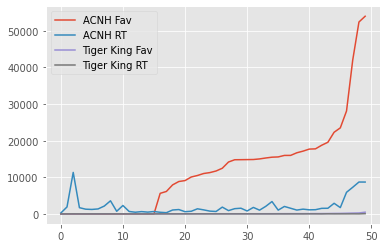

In [32]:
combined.plot()

<AxesSubplot:>

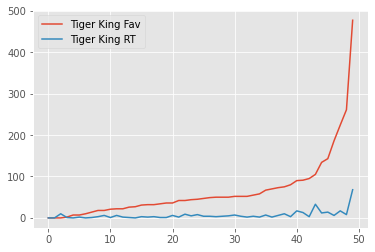

In [33]:
tk_stats.plot()

### Exercise


Retreive the last 50 tweets with the hashtag #datavis in the SLC area, print the text and the username.